In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores = rp.named_steps['estimator'].get_data()

X, _, y, _, y_scores, _ = train_test_split(df_mf.values,
                                           df_rank.values,
                                           df_scores.values,
                                           test_size=0,
                                           random_state=42)
print(X.shape, y.shape, y_scores.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 37.6 s, sys: 3.62 s, total: 41.3 s
Wall time: 41.4 s


In [6]:
# from scipy.stats import rankdata
# y_ = np.array([rankdata(y_, method='ordinal') for y_ in y_scores])

In [15]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X, y, y_scores, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:  15 | Trn_Spearman:  0.3765 | Val_Spearman:  0.1401 | Trn_ACCLoss:  0.0116 | Val_ACCLoss:  0.0467 | Trn_NDCG:  0.8345 | Val_NDCG:  0.6677
Fold   2 | #Est:  24 | Trn_Spearman:  0.3490 | Val_Spearman:  0.1300 | Trn_ACCLoss:  0.0197 | Val_ACCLoss:  0.1951 | Trn_NDCG:  0.7917 | Val_NDCG:  0.6257
Fold   3 | #Est:  57 | Trn_Spearman:  0.4119 | Val_Spearman:  0.2720 | Trn_ACCLoss:  0.0114 | Val_ACCLoss:  0.0347 | Trn_NDCG:  0.8328 | Val_NDCG:  0.6113
Fold   4 | #Est:   9 | Trn_Spearman:  0.3258 | Val_Spearman:  0.0943 | Trn_ACCLoss:  0.0387 | Val_ACCLoss:  0.0541 | Trn_NDCG:  0.7524 | Val_NDCG:  0.6571
Fold   5 | #Est:   2 | Trn_Spearman:  0.3333 | Val_Spearman:  0.0009 | Trn_ACCLoss:  0.0380 | Val_ACCLoss:  0.0456 | Trn_NDCG:  0.7201 | Val_NDCG:  0.5920
Fold   6 | #Est:  34 | Trn_Spearman:  0.3798 | Val_Spearman: -0.0147 | Trn_ACCLoss:  0.0183 | Val_ACCLoss:  0.0976 | Trn_NDCG:  0.8084 | Val_NDCG:  0.6245
Fold   7 | #Est:   5 | Trn_Spearman:  0.4486 | Val_Spearman:  0.0907 |

In [38]:
from sklearn.model_selection import KFold
from project.ranker.ltr_rankers import cv_random
from project.ranker.ranker import RandomRankingPredictor

rr = RandomRankingPredictor()
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
results_random = cv_random(rr, X, y, y_scores, kfolds)

Fold   1 | Trn_Spearman:  0.0472 | Val_Spearman: -0.0586 | Trn_ACCLoss:  0.1334 | Val_ACCLoss:  0.1588
Fold   2 | Trn_Spearman:  0.0617 | Val_Spearman:  0.0962 | Trn_ACCLoss:  0.1141 | Val_ACCLoss:  0.1528
Fold   3 | Trn_Spearman: -0.0274 | Val_Spearman: -0.0357 | Trn_ACCLoss:  0.1541 | Val_ACCLoss:  0.0356
Fold   4 | Trn_Spearman: -0.0170 | Val_Spearman: -0.2070 | Trn_ACCLoss:  0.1430 | Val_ACCLoss:  0.2081
Fold   5 | Trn_Spearman:  0.0386 | Val_Spearman: -0.0055 | Trn_ACCLoss:  0.1196 | Val_ACCLoss:  0.0542
Fold   6 | Trn_Spearman:  0.0134 | Val_Spearman:  0.0211 | Trn_ACCLoss:  0.1274 | Val_ACCLoss:  0.0599
Fold   7 | Trn_Spearman: -0.0137 | Val_Spearman: -0.1493 | Trn_ACCLoss:  0.1520 | Val_ACCLoss:  0.2885
Fold   8 | Trn_Spearman:  0.0161 | Val_Spearman:  0.2234 | Trn_ACCLoss:  0.1634 | Val_ACCLoss:  0.1092
Fold   9 | Trn_Spearman:  0.0620 | Val_Spearman: -0.2115 | Trn_ACCLoss:  0.1114 | Val_ACCLoss:  0.1709
Fold  10 | Trn_Spearman: -0.0510 | Val_Spearman: -0.0128 | Trn_ACCLoss:  

In [101]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X, y, y_scores, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, 
                  verbose_eval=False)

Fold   1 | #Est:  15 | Trn_Spearman:  0.3765 | Val_Spearman:  0.1401 | Trn_ACCLoss:  0.0116 | Val_ACCLoss:  0.0467 | Trn_NDCG:  0.8345 | Val_NDCG:  0.6677
Fold   2 | #Est:  24 | Trn_Spearman:  0.3490 | Val_Spearman:  0.1300 | Trn_ACCLoss:  0.0197 | Val_ACCLoss:  0.1951 | Trn_NDCG:  0.7917 | Val_NDCG:  0.6257
Fold   3 | #Est:  57 | Trn_Spearman:  0.4119 | Val_Spearman:  0.2720 | Trn_ACCLoss:  0.0114 | Val_ACCLoss:  0.0347 | Trn_NDCG:  0.8328 | Val_NDCG:  0.6113
Fold   4 | #Est:   9 | Trn_Spearman:  0.3258 | Val_Spearman:  0.0943 | Trn_ACCLoss:  0.0387 | Val_ACCLoss:  0.0541 | Trn_NDCG:  0.7524 | Val_NDCG:  0.6571
Fold   5 | #Est:   2 | Trn_Spearman:  0.3333 | Val_Spearman:  0.0009 | Trn_ACCLoss:  0.0380 | Val_ACCLoss:  0.0456 | Trn_NDCG:  0.7201 | Val_NDCG:  0.5920
Fold   6 | #Est:  34 | Trn_Spearman:  0.3798 | Val_Spearman: -0.0147 | Trn_ACCLoss:  0.0183 | Val_ACCLoss:  0.0976 | Trn_NDCG:  0.8084 | Val_NDCG:  0.6245
Fold   7 | #Est:   5 | Trn_Spearman:  0.4486 | Val_Spearman:  0.0907 |

In [100]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 50, 
          'num_leaves': 37, 'min_sum_hessian_in_leaf': 2.838955470674485, 'min_data_in_leaf': 4, 
          'bagging_fraction': 0.41761591951124705, 'bagging_freq': 4, 'feature_fraction': 0.6258773979549109, 
          'scale_pos_weight': 1.1049055615452428, 'learning_rate': 0.02887716145050293, 'lambda_l2': 29.235934351290478}
tuned_results, tuned_models = cv_lgbm(lightgbm, X, y, y_scores, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, 
                  verbose_eval=False)

Fold   1 | #Est:  36 | Trn_Spearman:  0.4350 | Val_Spearman:  0.2628 | Trn_ACCLoss:  0.0108 | Val_ACCLoss:  0.0418 | Trn_NDCG:  0.8178 | Val_NDCG:  0.6725
Fold   2 | #Est:  51 | Trn_Spearman:  0.4309 | Val_Spearman:  0.0302 | Trn_ACCLoss:  0.0058 | Val_ACCLoss:  0.0824 | Trn_NDCG:  0.8695 | Val_NDCG:  0.6208
Fold   3 | #Est:  48 | Trn_Spearman:  0.4340 | Val_Spearman:  0.0183 | Trn_ACCLoss:  0.0170 | Val_ACCLoss:  0.0352 | Trn_NDCG:  0.8520 | Val_NDCG:  0.5873
Fold   4 | #Est:  31 | Trn_Spearman:  0.4279 | Val_Spearman:  0.2097 | Trn_ACCLoss:  0.0045 | Val_ACCLoss:  0.1033 | Trn_NDCG:  0.8653 | Val_NDCG:  0.6623
Fold   5 | #Est:   1 | Trn_Spearman:  0.0739 | Val_Spearman: -0.0311 | Trn_ACCLoss:  0.1063 | Val_ACCLoss:  0.0499 | Trn_NDCG:  0.5541 | Val_NDCG:  0.5402
Fold   6 | #Est:  65 | Trn_Spearman:  0.4493 | Val_Spearman:  0.0769 | Trn_ACCLoss:  0.0030 | Val_ACCLoss:  0.0450 | Trn_NDCG:  0.8863 | Val_NDCG:  0.6748
Fold   7 | #Est:   8 | Trn_Spearman:  0.3239 | Val_Spearman:  0.1172 |

In [122]:
ar = pd.read_csv('results/AR.csv')
knn = pd.read_csv('results/k_best(16).csv')
arm = pd.read_csv('results/AR_manhattan.csv')
knnm = pd.read_csv('results/kbest_manhattan.csv')
ar.shape, knn.shape, arm.shape, knnm.shape

((100, 3), (100, 3), (100, 2), (100, 2))

In [139]:
acc = pd.DataFrame()
acc['Random'] = results_random[:,3]
acc['AR'] = ar.acc_loss
acc['AR Manhattan'] = arm.acc_loss
acc['KNN'] = knn.acc_loss
acc['KNN Manhattan'] = knnm.acc_loss
acc['LGBM'] = results[:,3]
acc['Tuned LGBM'] = tuned_results[:,3]
acc.to_csv('results/ACC_scores.csv', index=False)

In [140]:
acc.shape

(100, 7)

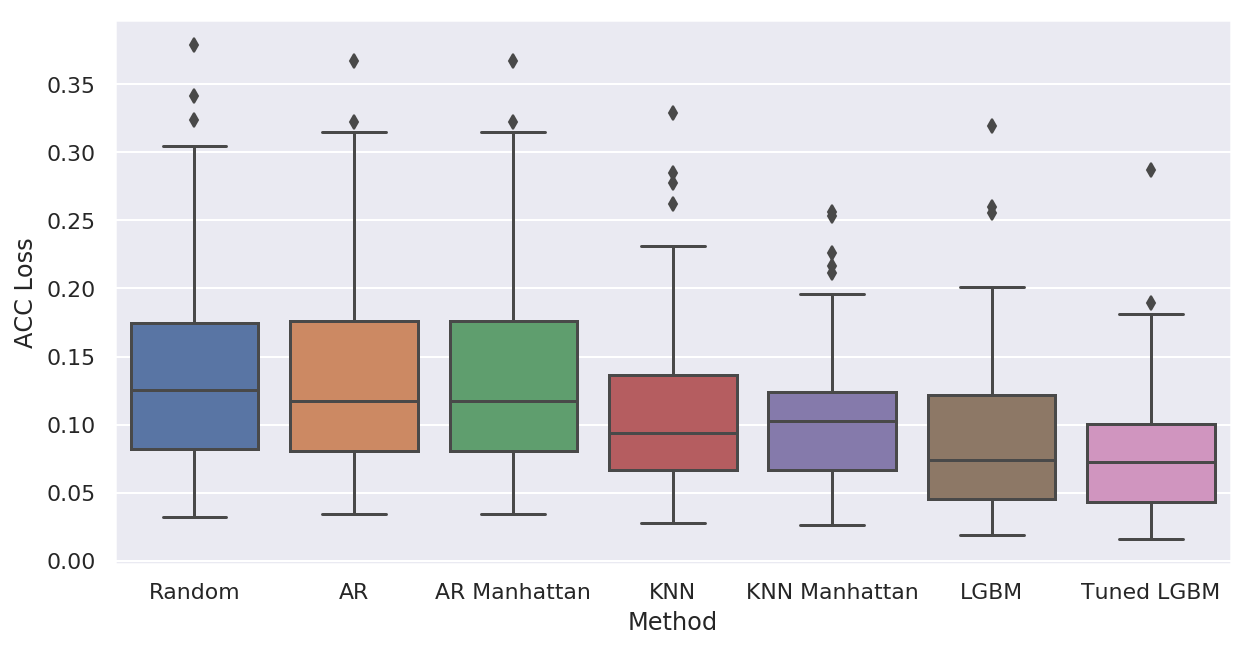

In [141]:
acc = pd.melt(acc, value_vars=['Random', 'AR', 'AR Manhattan', 'KNN', 'KNN Manhattan', 'LGBM', 'Tuned LGBM'], 
              var_name='Ranking Method', value_name='ACC Loss')

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='Ranking Method', y='ACC Loss', data=acc)

In [104]:
results[:,3].mean(), tuned_results[:,3].mean()

(0.08778466266450341, 0.07973724434740015)

## Bayesian Optimization

In [62]:
from skopt.space import Real, Integer, Categorical

space  = [
    Integer(3, 50, name='max_depth'),
    Integer(3, 50, name='num_leaves'),
    Real(0, 20, name='min_sum_hessian_in_leaf'),
    Integer(1, 30, name='min_data_in_leaf'),

    Real(0.4, 1, name='bagging_fraction'),
    Integer(1, 30, name='bagging_freq'),
    Real(0.4, 1, name='feature_fraction'),

    Real(1, 7,  name='scale_pos_weight'),

    Real(-3, -1.5, name='learning_rate'),
    Real(0, 1.5, name='lambda_l2'),
]

In [66]:
import gc

def objective(values):
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_at': y.shape[1],
        
        'max_depth': values[0],
        'num_leaves': values[1], 
        'min_sum_hessian_in_leaf': values[2],
        'min_data_in_leaf': values[3],
        
        'bagging_fraction': values[4],
        'bagging_freq': values[5],
        'feature_fraction': values[6],
        
        'scale_pos_weight': values[7],
        
        'learning_rate': 10 ** values[8], 
        'lambda_l2': 10 ** values[9],
    }
    print('\nNext set of params.....', params)
    kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
    res, mod = cv_lgbm(lightgbm, X, y, y_scores, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, 
                  verbose_eval=False, verbose_folds=False)
    gc.collect()
    return res[:,3].mean()

{'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 9, 'num_leaves': 41, 'min_sum_hessian_in_leaf': 1.5599693156685792, 'min_data_in_leaf': 2, 'bagging_fraction': 0.4195319900974406, 'bagging_freq': 3, 'feature_fraction': 0.9545642702236832, 'scale_pos_weight': 2.678789176617139, 'learning_rate': 0.030394763736504227, 'lambda_l2': 1.1544193457744014}

{'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 50, 'num_leaves': 37, 'min_sum_hessian_in_leaf': 2.838955470674485, 'min_data_in_leaf': 4, 'bagging_fraction': 0.41761591951124705, 'bagging_freq': 4, 'feature_fraction': 0.6258773979549109, 'scale_pos_weight': 1.1049055615452428, 'learning_rate': 0.02887716145050293, 'lambda_l2': 29.235934351290478}

In [ ]:
%%time
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_random_starts=10, n_calls=100, random_state=42, verbose=True)
print(f'Best score = {res_gp.fun:.4f}')

Iteration No: 1 started. Evaluating function at random point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 40, 'num_leaves': 12, 'min_sum_hessian_in_leaf': 15.59382000545539, 'min_data_in_leaf': 18, 'bagging_fraction': 0.6674996517121548, 'bagging_freq': 4, 'feature_fraction': 0.6755493351795203, 'scale_pos_weight': 3.0022516668341312, 'learning_rate': 0.0016379484405271854, 'lambda_l2': 9.46962343599151}

Trn_Spearman:  0.2486 +/-0.0895 | Val_Spearman:  0.0953 +/-0.1413
Trn_ACCLoss:   0.0593 +/-0.0223 | Val_ACCLoss:   0.0957 +/-0.0538
Trn_NDCG:      0.6716 +/-0.0489 | Val_NDCG:      0.6135 +/-0.0546

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.9107
Function value obtained: 0.0957
Current minimum: 0.0957
Iteration No: 2 started. Evaluating function at random point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 6, 'num_leaves': 37, 'min_sum_hessian_in_lea

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



Trn_Spearman:  0.3506 +/-0.1948 | Val_Spearman:  0.0687 +/-0.1624
Trn_ACCLoss:   0.0351 +/-0.0411 | Val_ACCLoss:   0.0819 +/-0.0458
Trn_NDCG:      0.7912 +/-0.1404 | Val_NDCG:      0.6235 +/-0.0549

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 17.8192
Function value obtained: 0.0819
Current minimum: 0.0797
Iteration No: 81 started. Searching for the next optimal point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 27, 'num_leaves': 50, 'min_sum_hessian_in_leaf': 17.41264011407018, 'min_data_in_leaf': 1, 'bagging_fraction': 0.44369303146638234, 'bagging_freq': 2, 'feature_fraction': 0.9704973124928695, 'scale_pos_weight': 2.0643781574229747, 'learning_rate': 0.0014745538921914529, 'lambda_l2': 2.001191182661689}

Trn_Spearman:  0.3775 +/-0.1467 | Val_Spearman:  0.1045 +/-0.1532
Trn_ACCLoss:   0.0304 +/-0.0362 | Val_ACCLoss:   0.0852 +/-0.0487
Trn_NDCG:      0.8030 +/-0.1170 | Val_NDCG:      0.6322 +

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



Trn_Spearman:  0.3506 +/-0.1948 | Val_Spearman:  0.0687 +/-0.1624
Trn_ACCLoss:   0.0351 +/-0.0411 | Val_ACCLoss:   0.0819 +/-0.0458
Trn_NDCG:      0.7912 +/-0.1404 | Val_NDCG:      0.6235 +/-0.0549

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 18.8822
Function value obtained: 0.0819
Current minimum: 0.0797
Iteration No: 86 started. Searching for the next optimal point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 16, 'num_leaves': 50, 'min_sum_hessian_in_leaf': 16.646153150741515, 'min_data_in_leaf': 7, 'bagging_fraction': 0.9667694013056308, 'bagging_freq': 6, 'feature_fraction': 0.9467367007848115, 'scale_pos_weight': 1.0104062644412466, 'learning_rate': 0.0013560322832317628, 'lambda_l2': 3.0535335827894428}

Trn_Spearman:  0.4034 +/-0.0977 | Val_Spearman:  0.1125 +/-0.1266
Trn_ACCLoss:   0.0203 +/-0.0237 | Val_ACCLoss:   0.0994 +/-0.0651
Trn_NDCG:      0.8180 +/-0.0786 | Val_NDCG:      0.6224 

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



Trn_Spearman:  0.3506 +/-0.1948 | Val_Spearman:  0.0687 +/-0.1624
Trn_ACCLoss:   0.0351 +/-0.0411 | Val_ACCLoss:   0.0819 +/-0.0458
Trn_NDCG:      0.7912 +/-0.1404 | Val_NDCG:      0.6235 +/-0.0549

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 19.4337
Function value obtained: 0.0819
Current minimum: 0.0797
Iteration No: 90 started. Searching for the next optimal point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 48, 'num_leaves': 18, 'min_sum_hessian_in_leaf': 13.961334603649401, 'min_data_in_leaf': 30, 'bagging_fraction': 0.5165927284003068, 'bagging_freq': 30, 'feature_fraction': 0.5078505310662691, 'scale_pos_weight': 6.3644652623219535, 'learning_rate': 0.021646154858438873, 'lambda_l2': 6.064180293125092}

Trn_Spearman:  0.1373 +/-0.0896 | Val_Spearman:  0.0388 +/-0.1419
Trn_ACCLoss:   0.0860 +/-0.0228 | Val_ACCLoss:   0.1061 +/-0.0643
Trn_NDCG:      0.6214 +/-0.0489 | Val_NDCG:      0.6006 

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



Trn_Spearman:  0.3506 +/-0.1948 | Val_Spearman:  0.0687 +/-0.1624
Trn_ACCLoss:   0.0351 +/-0.0411 | Val_ACCLoss:   0.0819 +/-0.0458
Trn_NDCG:      0.7912 +/-0.1404 | Val_NDCG:      0.6235 +/-0.0549

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 18.1131
Function value obtained: 0.0819
Current minimum: 0.0797
Iteration No: 92 started. Searching for the next optimal point.

Next set of params..... {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_at': 13, 'max_depth': 48, 'num_leaves': 30, 'min_sum_hessian_in_leaf': 14.583628930227672, 'min_data_in_leaf': 2, 'bagging_fraction': 0.4142871018031466, 'bagging_freq': 1, 'feature_fraction': 0.9346860959197708, 'scale_pos_weight': 3.73453357804497, 'learning_rate': 0.0016693176869434652, 'lambda_l2': 30.838933782289068}

Trn_Spearman:  0.3029 +/-0.1505 | Val_Spearman:  0.0981 +/-0.1649
Trn_ACCLoss:   0.0406 +/-0.0377 | Val_ACCLoss:   0.0838 +/-0.0506
Trn_NDCG:      0.7551 +/-0.1132 | Val_NDCG:      0.6315 +/

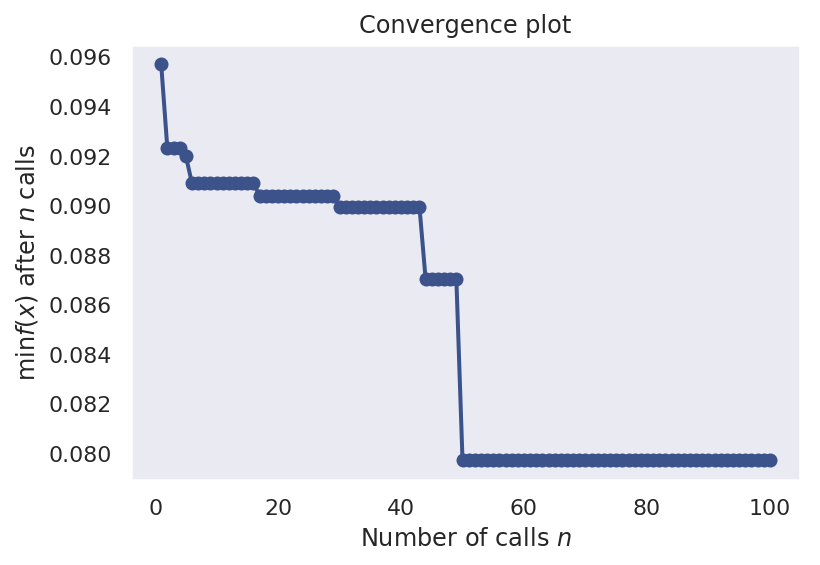

In [70]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [71]:
res_gp.x

[50,
 37,
 2.838955470674485,
 4,
 0.41761591951124705,
 4,
 0.6258773979549109,
 1.1049055615452428,
 -1.5394454990168742,
 1.4659169780134027]

In [72]:
res_gp.fun

0.07973724434740015

In [81]:
cols = ['iteration', 'ACC_Loss', 'max_depth', 'num_leaves', 'min_sum_hessian_in_leaf', 
        'min_data_in_leaf', 'bagging_fraction', 'bagging_freq', 'feature_fraction', 
        'scale_pos_weight', 'learning_rate', 'lambda_l2']
gp_results = [[i+1, f, *p] for i, (f, p) in enumerate(zip(res_gp.func_vals, res_gp.x_iters))]
gp_results = pd.DataFrame(gp_results, columns=cols)

In [82]:
gp_results.head()

,iteration,ACC_Loss,max_depth,num_leaves,min_sum_hessian_in_leaf,min_data_in_leaf,bagging_fraction,bagging_freq,feature_fraction,scale_pos_weight,learning_rate,lambda_l2
0,1,0.095691,40,12,15.593820,18,0.667500,4,0.675549,3.002252,-2.785700,0.976333
1,2,0.092302,6,37,18.771054,1,0.995327,19,0.766992,1.042398,-2.965406,0.787162
2,3,0.113326,22,5,19.475110,8,0.454364,19,0.629477,6.899385,-2.299856,1.289911
3,4,0.100288,35,24,0.265299,28,0.737973,12,0.409580,2.385363,-2.638462,1.024895
4,5,0.092008,32,42,3.467293,12,0.509342,23,0.655094,2.247650,-2.148450,0.046970


In [83]:
gp_results.sort_values('ACC_Loss').head(10)

,iteration,ACC_Loss,max_depth,num_leaves,min_sum_hessian_in_leaf,min_data_in_leaf,bagging_fraction,bagging_freq,feature_fraction,scale_pos_weight,learning_rate,lambda_l2
49,50,0.079737,50,37,2.838955,4,0.417616,4,0.625877,1.104906,-1.539445,1.465917
94,95,0.080895,50,50,0.000000,1,0.592168,1,1.000000,1.000000,-1.500000,0.000000
90,91,0.081851,50,50,20.000000,1,0.400000,1,0.400000,1.000000,-1.500000,0.000000
88,89,0.081851,50,50,20.000000,1,0.400000,1,0.400000,1.000000,-1.500000,0.000000
84,85,0.081851,50,50,20.000000,1,0.400000,1,0.400000,1.000000,-1.500000,0.000000
79,80,0.081851,50,50,20.000000,1,0.400000,1,0.400000,1.000000,-1.500000,0.000000
77,78,0.081851,50,50,20.000000,1,0.400000,1,0.400000,1.000000,-1.500000,0.000000
97,98,0.083065,50,50,0.000000,1,0.400000,1,1.000000,1.000000,-1.500000,0.000000
92,93,0.083764,49,50,0.504879,6,0.481696,1,0.989278,4.235654,-2.988723,0.361351
91,92,0.083811,48,30,14.583629,2,0.414287,1,0.934686,3.734534,-2.777461,1.489099


In [84]:
gp_results.to_csv('results/gp_optimization.csv', index=False)

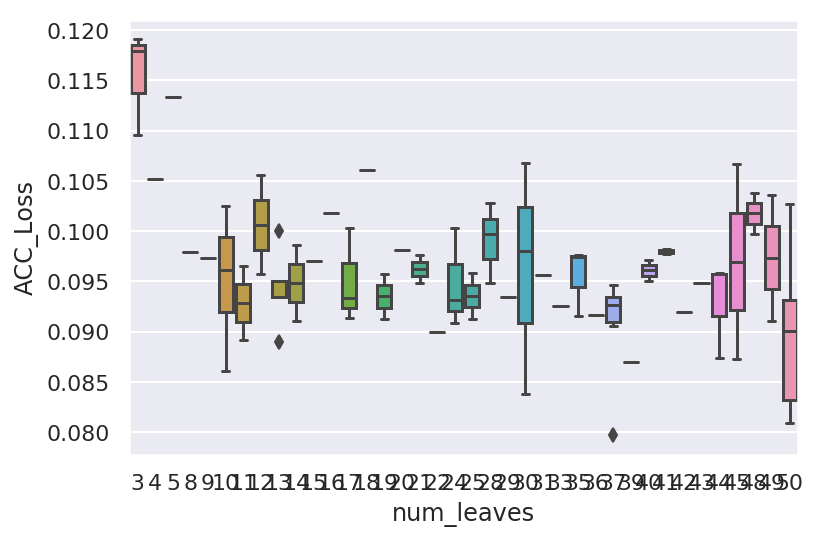

In [97]:
sns.boxplot(x='num_leaves', y='ACC_Loss', data=gp_results)

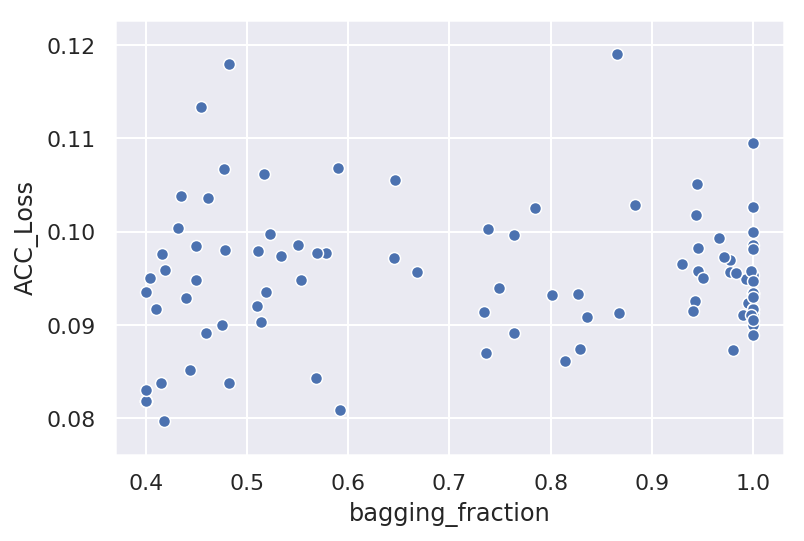

In [92]:
sns.scatterplot(x='bagging_fraction', y='ACC_Loss', data=gp_results)

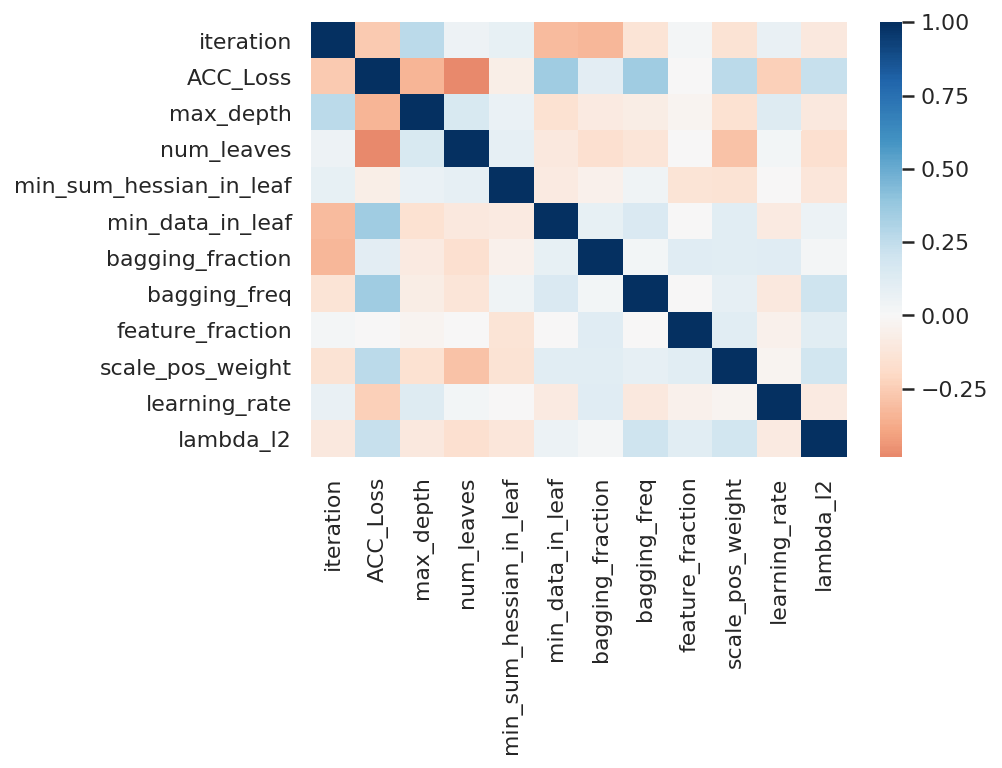

In [96]:
sns.heatmap(gp_results.corr(), cmap='RdBu', center=0)

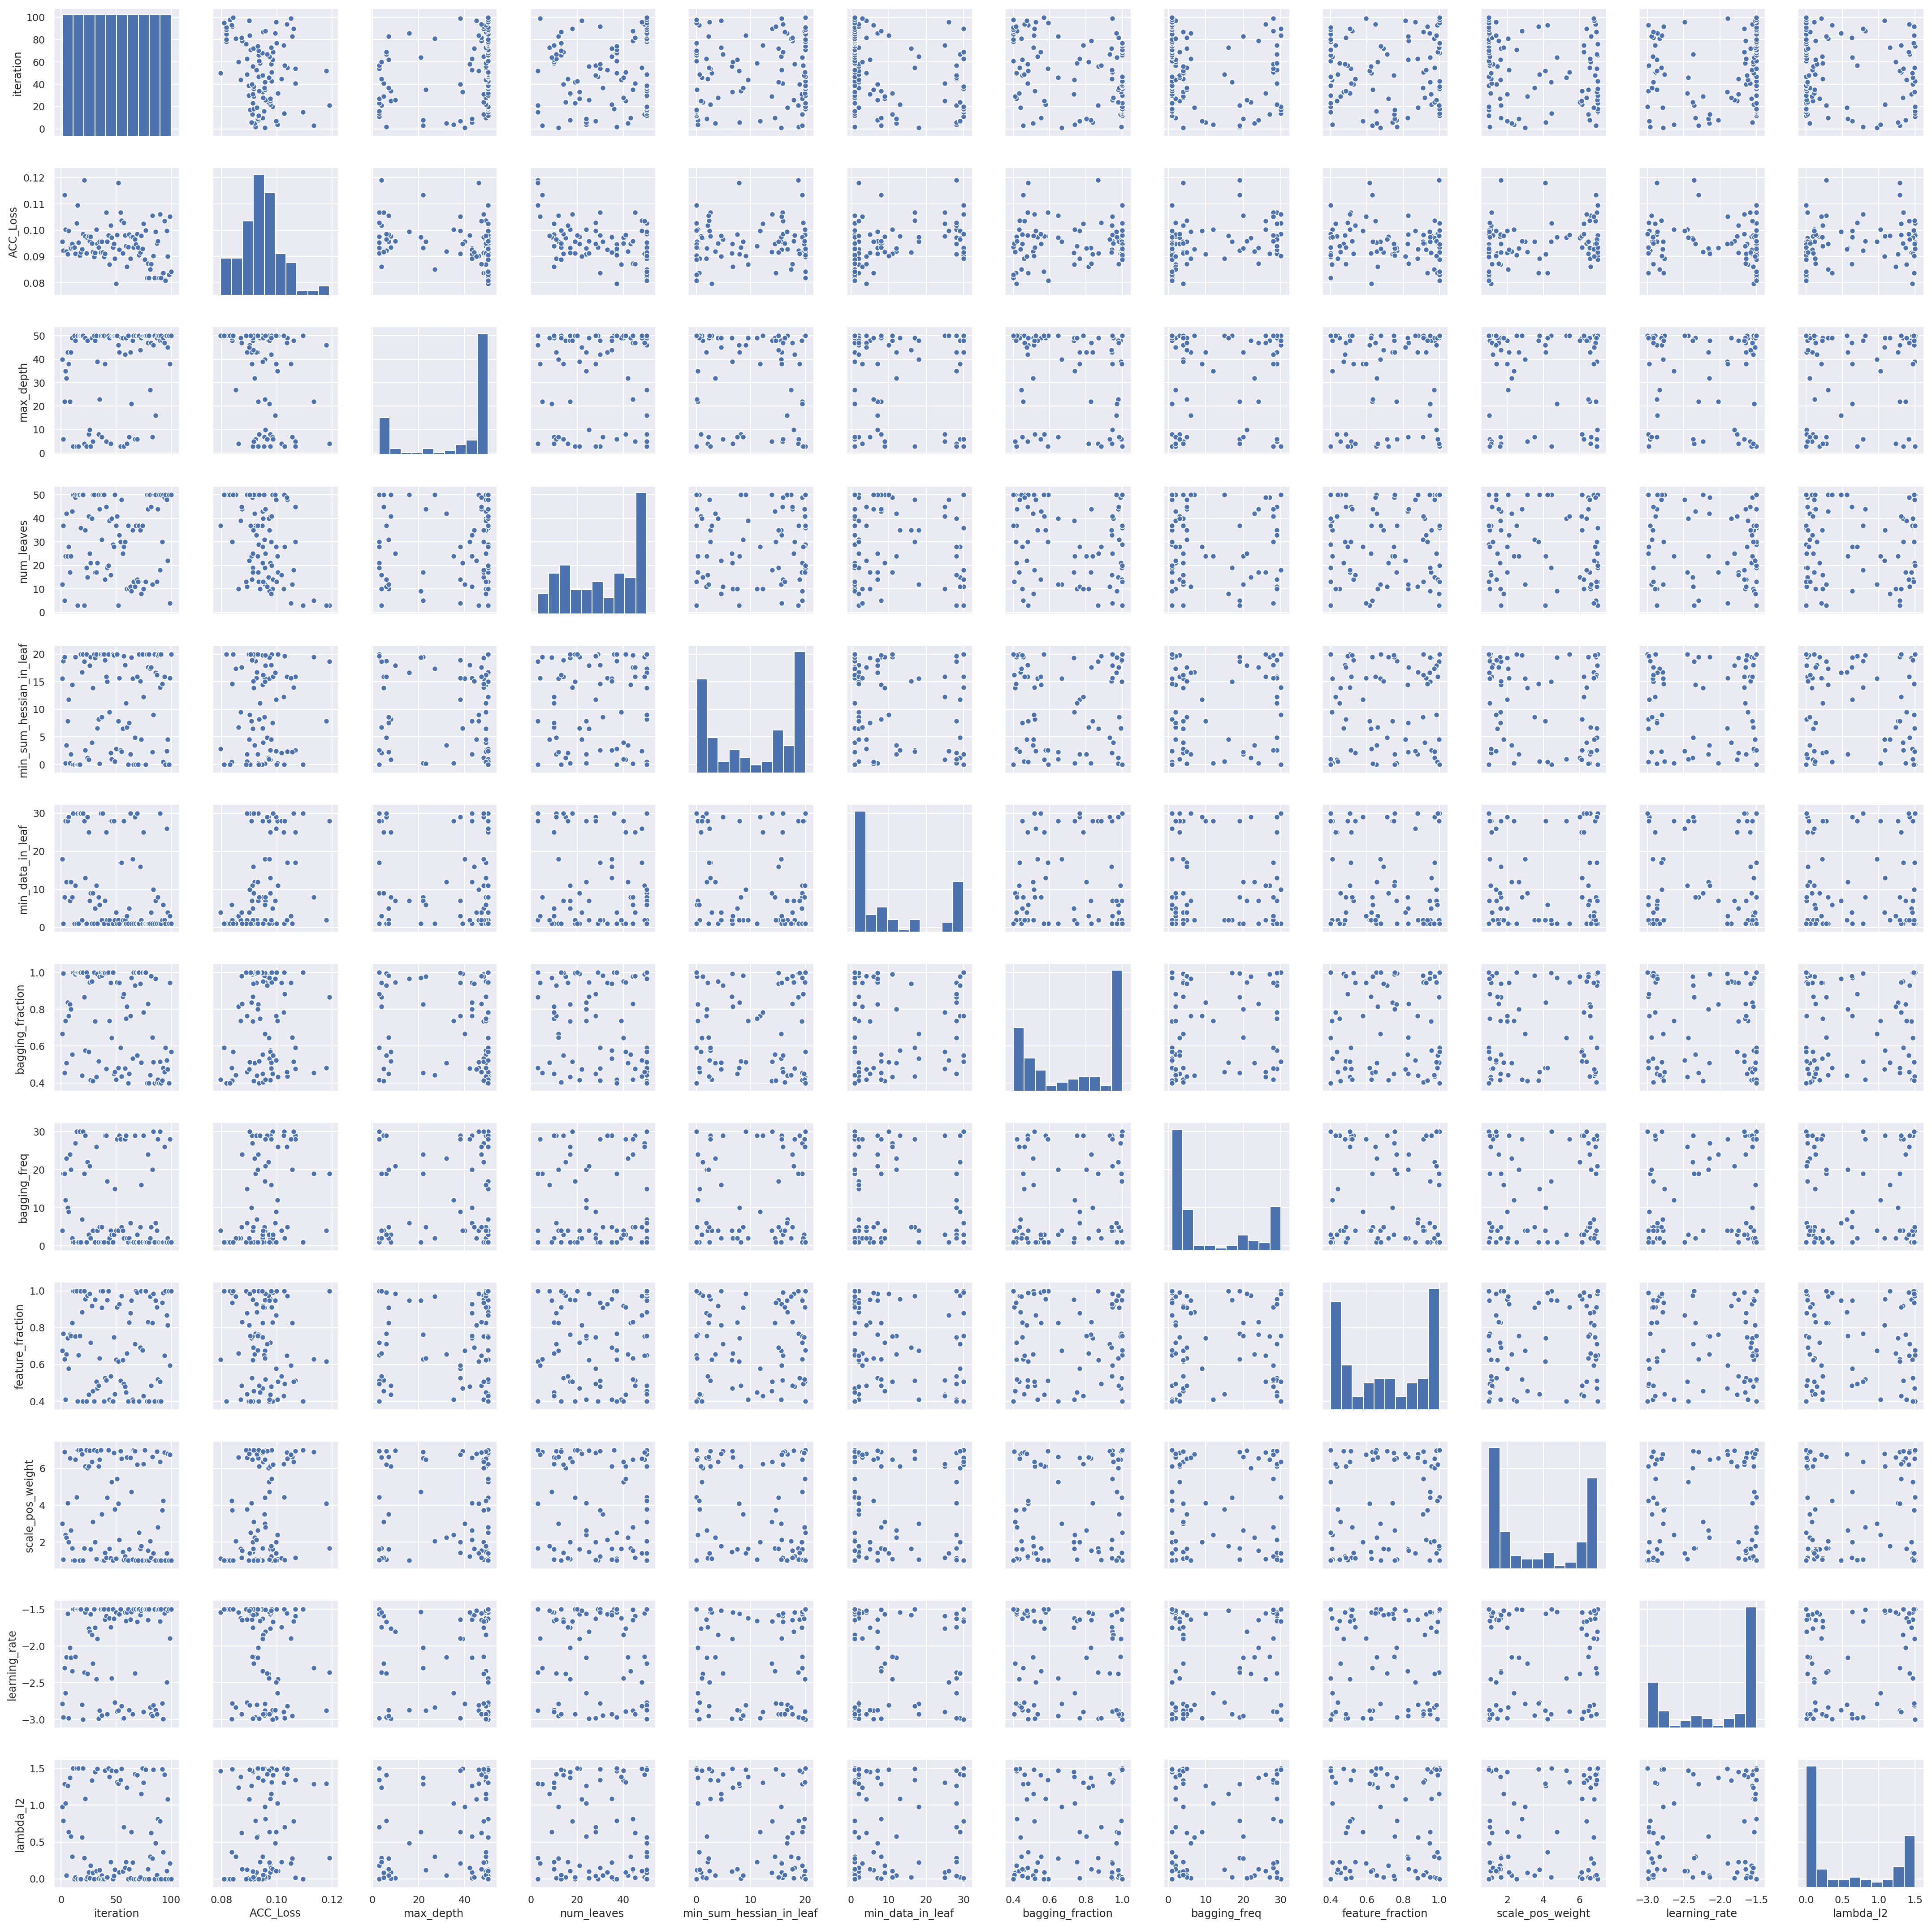

In [93]:
sns.pairplot(gp_results)

In [ ]:
sns.boxplot(x='min_data_in_leaf', y='ACC_Loss', data=gp_results)